# Exp 016: Analyze Performance in Grammar-Controlled Response Generation
This experiment creates descriptive statistics for the evaluation of different models to solve the problem.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import random

import sys
sys.path.append("../source")
import importlib
#importlib.reload(helpers)
from helpers import format_context, egp, get_prompt_task_2, get_preferred_nrs
from evaluation import calculate_distinct_n

[nltk_data] Downloading package punkt to
[nltk_data]     /scratch/tmp.61309865.dglandorf...
[nltk_data]   Package punkt is already up-to-date!


In [2]:

quality_indicators = ['Appropriateness', 'Relevance', 'Content Richness', 'Grammatical Correctness']

def get_aggs(results, by=['model', 'num_constraints'], distinct=False):
    distinct = {'responses0': calculate_distinct_n} if distinct else {}
    neg_const = {'num_constraints_neg': ['mean']} if 'num_constraints_neg' in results.columns else {}
    aggs = results.groupby(by).agg({'num_constraints_sat': ['mean', 'count'],
                                    **neg_const,
                                    **distinct,
                                    **{col: ['mean', 'count'] for col in ['Appropriateness',
                                                                          'Relevance',
                                                                          'Content Richness',
                                                                          'Grammatical Correctness']}})
    return aggs

def plot_sat(res, col='num_constraints_sat', by='num_constraints', xlabel="Number of constraints", title="Relative amount of satisfied constraints"):
    get_aggs(res, ["model", by]).unstack(level=0)[col]['mean'].plot(kind='bar', rot=0)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.ylabel("Success Rate")
    plt.xlabel(xlabel)
    plt.ylim(0,1)
    plt.title(title)
    plt.legend(title='Legend', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

def plot_distinct(single, name):
    x=single['responses0']['calculate_distinct_n']
    y=single['num_constraints_sat']['mean']
    ax = sns.scatterplot(x=x, y=y)
    ax.set_ylabel("Constraint Satisfaction")
    ax.set_xlabel("Distinct-2")
    ax.set_title(f"{name}: Single Constraint Satisfaction and Distinctiveness per Skill")
    for i, txt in enumerate(single.index):
        ax.annotate(txt, (x.iloc[i]+0.01, y.iloc[i]-0.02))
        pass  
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    ax.axis(xmin=0.,xmax=1., ymin=0.,ymax=1.)
    plt.axvline(x=x.mean(), color='r', linestyle='--', label='Mean')
    plt.show()

def get_mean_distinct(model):
    return get_aggs(single_constraints[single_constraints['model']==model], ["constraint"], distinct=True)['responses0']['calculate_distinct_n'].mean()


# Task 1

In [13]:
#models = ["gpt35", "llama", "llama-FT-multi", "llama-decoding"]# "llama-FT-decoding"
models = ["decoding-0","decoding-10","decoding-20", "decoding-50", "decoding-50-2","decoding-100", "decoding-1000"]
res = pd.DataFrame()

for model in models:
    results = pd.read_json(f"../data/task1/{model}_eval.json")
    results['model']=model
    results = results[results['responses'].apply(len)>0]
    results['responses0'] = results['responses'].apply(lambda x: x[0])
    results['num_constraints'] = results['constraints'].apply(len)
    results['num_constraints_sat'] = results['positive_constraints'].apply(lambda x: np.count_nonzero(x)) / results['num_constraints']
    res = pd.concat([res, results])

single_constraints = res[res['num_constraints']==1].copy()
single_constraints['constraint'] = single_constraints['constraints'].apply(lambda x: x[0])

In [14]:
get_aggs(res, by=["model"])

num_constraints_sat       Appropriateness       Relevance        \
                             mean count            mean count      mean count   
model                                                                           
decoding-0               0.377778    60             NaN     0       NaN     0   
decoding-10              0.458333    60             NaN     0       NaN     0   
decoding-100             0.675000    60             NaN     0       NaN     0   
decoding-1000            0.729167    60             NaN     0       NaN     0   
decoding-20              0.529167    60             NaN     0       NaN     0   
decoding-50              0.681944    60             NaN     0       NaN     0   
decoding-50-2            0.625000    60             NaN     0       NaN     0   

              Content Richness       Grammatical Correctness        
                          mean count                    mean count  
model                                                               
decoding-0                 NaN     0                     NaN     0  
decoding-10                NaN     0                     NaN     0  
decoding-100               NaN     0                     NaN     0  
decoding-1000              NaN     0                     NaN     0  
decoding-20                NaN     0                     NaN     0  
decoding-50                NaN     0                     NaN     0  
decoding-50-2              NaN     0                     NaN     0

## Qualitative evaluation

Pick a random test case and print answers from all models

In [4]:
case = res.loc[random.randint(0, max(res.index))]
print("=== DIALOG ===")
print(format_context(case.iloc[0]['context']))
constraints = case.iloc[0]['constraints']
print("=== CONSTRAINTS ===")
for statement in egp[egp['#'].isin(constraints)]['Can-do statement']:
    print(statement)
print("=== RESPONSES ===")
for model in models: 
    print(f"Model: {model}")
    responses = case[case['model']==model]
    if not len(responses): continue
    print(f"{responses.iloc[0]['responses0']} ({responses.iloc[0]['num_constraints_sat']:.1%})")

=== DIALOG ===
A: Hi!
B: Hi!
A: So Batman vs Superman
B: So, you read a synopsis of a movie?  What was it called?
=== CONSTRAINTS ===
Can form negative statements of main verb 'be', with contracted and uncontracted forms.
=== RESPONSES ===
Model: gpt35
A: No, I didn't read a synopsis. I actually watched the movie. (0.0%)
Model: llama
A: I haven't read a synopsis of the movie, I just saw the trailer. (0.0%)
Model: llama-FT-multi
I'm not sure.  I read it on a website.  It wasn't that long ago.  I'm not sure if it was a movie or a book.  I know it wasn't a book.  It wasn't a book.  It was a movie.  It wasn't a book. (100.0%)
Model: llama-decoding
A: Isn't it just a silly movie, though? (100.0%)


## Quantitative Evaluation

In [5]:
get_aggs(single_constraints, ["model", "response_hit"])

num_constraints_sat       Appropriateness        \
                                           mean count            mean count   
model          response_hit                                                   
llama-decoding 0.0                     0.835862   725        3.098958   192   
               1.0                     0.823448   725        3.140625   192   

                            Relevance       Content Richness        \
                                 mean count             mean count   
model          response_hit                                          
llama-decoding 0.0           2.713542   192         2.744792   192   
               1.0           2.755208   192         2.807292   192   

                            Grammatical Correctness        
                                               mean count  
model          response_hit                                
llama-decoding 0.0                         4.838542   192  
               1.0                         4.828125   192

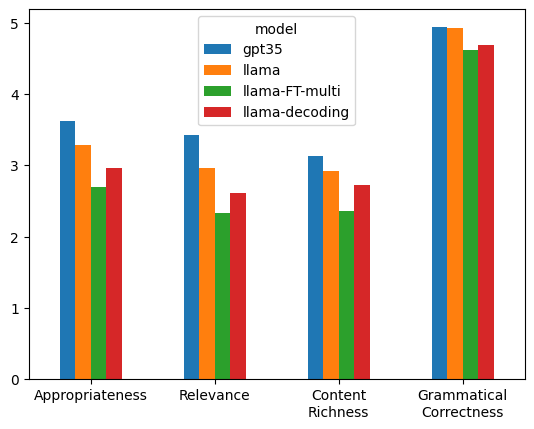

In [6]:
df =res.groupby(['model']).agg({**{col: 'mean' for col in quality_indicators}})
ax=df.transpose().plot(kind='bar', rot=0)
ax.set_xticklabels([l.get_text().replace(" ", "\n") for l in ax.get_xticklabels()])
plt.show()

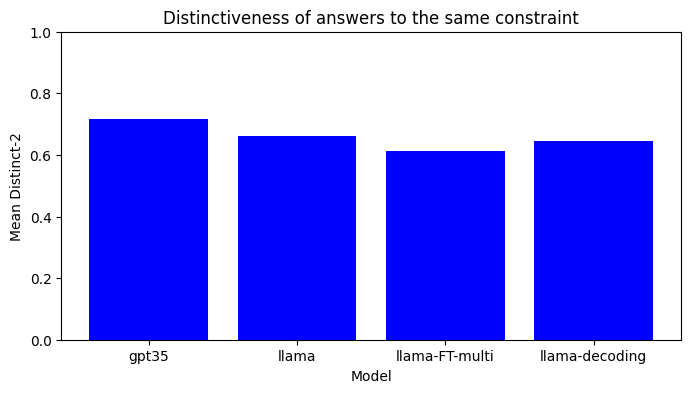

In [8]:
plt.figure(figsize=(8, 4))
plt.bar(models, [get_mean_distinct(model) for model in models], color='blue')
plt.xlabel('Model')
plt.ylabel('Mean Distinct-2')
plt.ylim(0,1)
plt.title('Distinctiveness of answers to the same constraint')
plt.show()

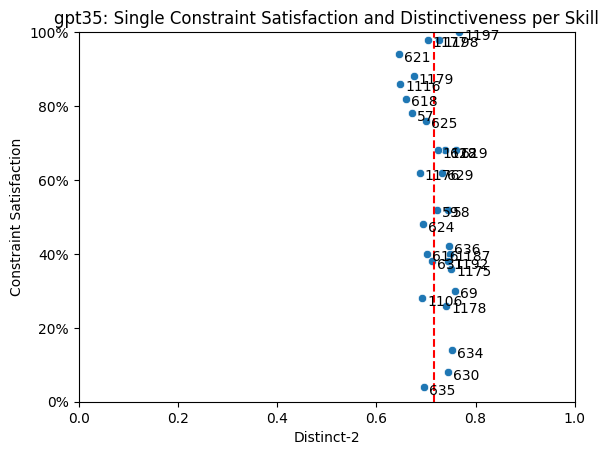

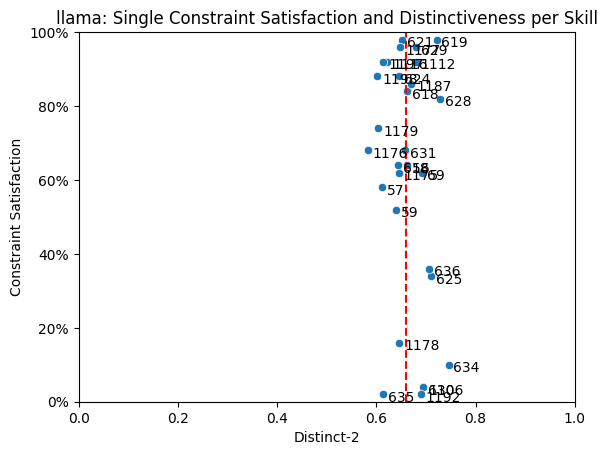

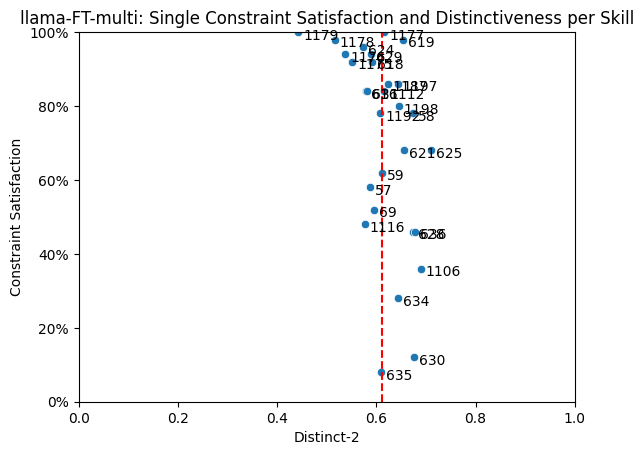

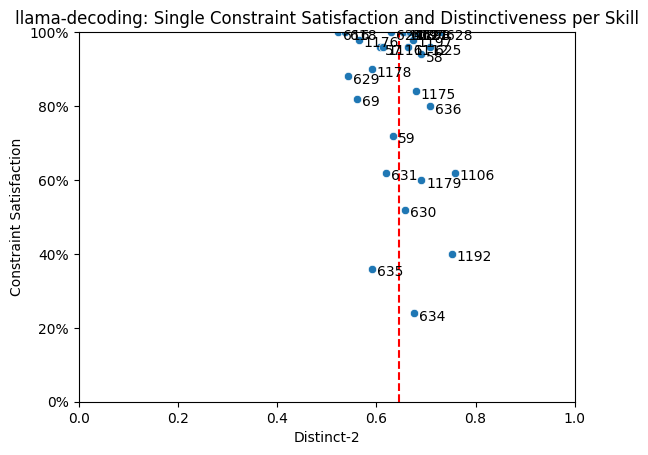

In [167]:
for model in models:
    plot_distinct(get_aggs(single_constraints[single_constraints['model']==model], ["constraint"], distinct=True), name=model)

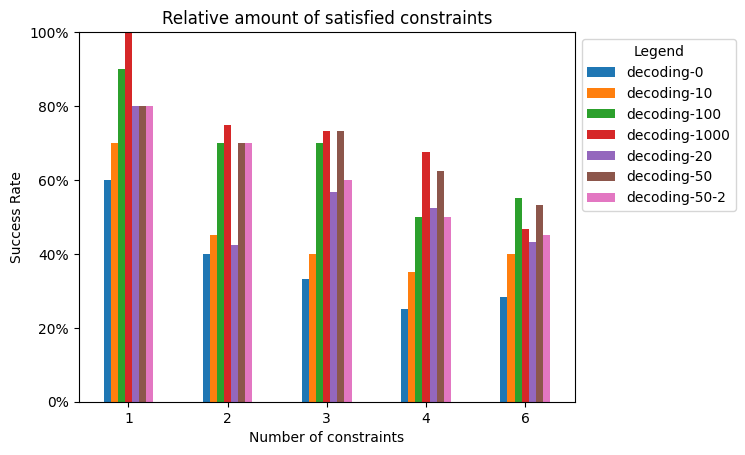

In [15]:
plot_sat(res)

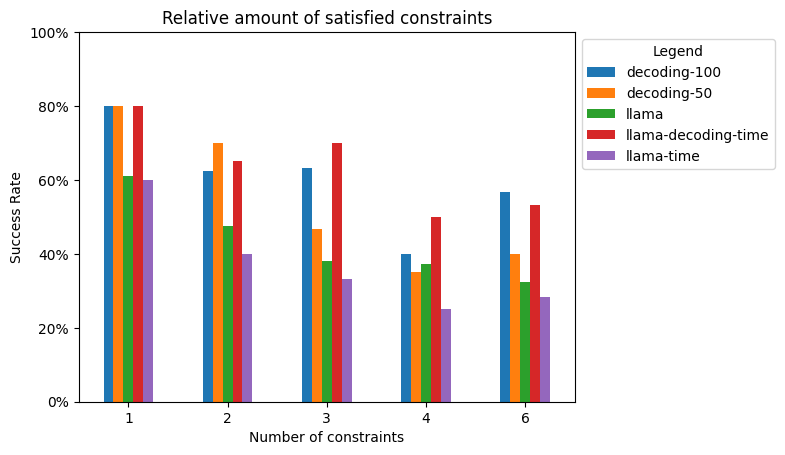

In [33]:
plot_sat(res)

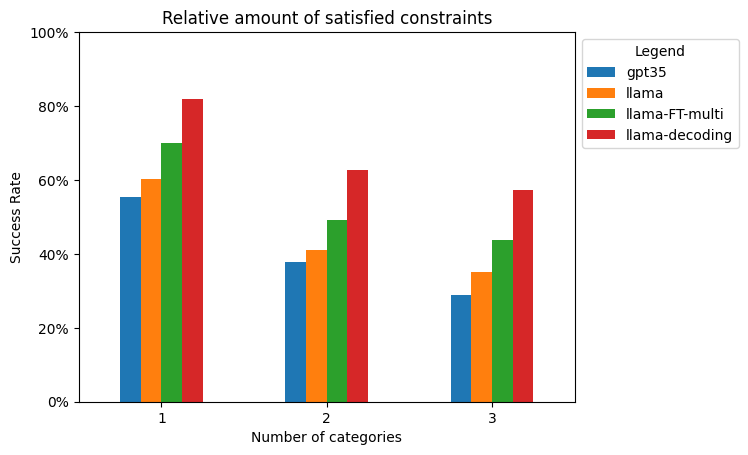

In [169]:
plot_sat(res, by="n_subcats", xlabel="Number of categories")

Report as a table

In [5]:
tab = get_aggs(res, ["model", "num_constraints"]).unstack(level=0)["num_constraints_sat"]['mean'].transpose()
translate_models(tab)
tab.iloc[:, :5] = tab.iloc[:, :5].applymap(lambda x: f'{x*100:.1f}%')
tab.columns.name = "Number of constraints"
tab

Number of constraints,1,2,3,4,6
GPT-3.5,56.0%,43.2%,27.7%,35.8%,30.2%
Llama3-8B,61.1%,47.5%,38.0%,37.2%,32.3%
Llama3-8B Finetuned,70.9%,55.5%,46.3%,45.0%,41.2%
Llama3-8B Decoding,83.0%,69.2%,60.0%,54.8%,54.8%


In [6]:
latex_table = tab.to_latex(escape=True)
print(latex_table)

\begin{tabular}{llllll}
\toprule
Number of constraints &      1 &      2 &      3 &      4 &      6 \\
\midrule
GPT-3.5             &  56.0\% &  43.2\% &  27.7\% &  35.8\% &  30.2\% \\
Llama3-8B           &  61.1\% &  47.5\% &  38.0\% &  37.2\% &  32.3\% \\
Llama3-8B Finetuned &  70.9\% &  55.5\% &  46.3\% &  45.0\% &  41.2\% \\
Llama3-8B Decoding  &  83.0\% &  69.2\% &  60.0\% &  54.8\% &  54.8\% \\
\bottomrule
\end{tabular}



/tmp/ipykernel_6510/921133908.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = tab.to_latex(escape=True)


In [7]:
def get_avg_wpm(model):
    times = pd.read_json(f"../data/task1/{model}-time.json")
    return f"{int((times['responses'].apply(lambda x: len(x[0].split())) / times['time'] * 60).mean().round(0))} wpm"

In [15]:
tab = pd.DataFrame()
for ind in quality_indicators:
    tab[ind] = get_aggs(single_constraints, ["model"])[ind]['mean']

tab['Distinct-2'] = [get_mean_distinct(model) for model in models]
tab['Inference'] = [get_avg_wpm(model) for model in models]
tab.iloc[:, :5] = tab.iloc[:, :5].round(2)
translate_models(tab)
tab.columns.name = ""
tab

,Appropriateness,Relevance,Content Richness,Grammatical Correctness,Distinct-2,Inference
GPT-3.5,3.68,3.49,3.13,4.95,0.72,1650 wpm
Llama3-8B,3.30,2.98,2.88,4.93,0.66,696 wpm
Llama3-8B Finetuned,2.76,2.39,2.35,4.66,0.61,633 wpm
Llama3-8B Decoding,3.12,2.73,2.78,4.83,0.65,373 wpm


In [16]:
latex_table = tab.to_latex(escape=True)
print(latex_table)

\begin{tabular}{lrrrrrl}
\toprule
{} &  Appropriateness &  Relevance &  Content Richness &  Grammatical Correctness &  Distinct-2 & Inference \\
\midrule
GPT-3.5             &             3.68 &       3.49 &              3.13 &                     4.95 &        0.72 &  1650 wpm \\
Llama3-8B           &             3.30 &       2.98 &              2.88 &                     4.93 &        0.66 &   696 wpm \\
Llama3-8B Finetuned &             2.76 &       2.39 &              2.35 &                     4.66 &        0.61 &   633 wpm \\
Llama3-8B Decoding  &             3.12 &       2.73 &              2.78 &                     4.83 &        0.65 &   373 wpm \\
\bottomrule
\end{tabular}



/tmp/ipykernel_19203/921133908.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = tab.to_latex(escape=True)


# Task 2

In [5]:
def categories_satisfied(row, type='positive'):
    df = pd.DataFrame({'score': row[f'{type}_constraints'], 'category': row[f'{type}_categories']})
    return np.mean(df.groupby("category").agg({"score": lambda x: np.count_nonzero(x)>0})['score'])

In [20]:
models = ["gpt35", "llama", "llama-FT-task1", "llama-decoding"]
res = pd.DataFrame()

for model in models:
    results = pd.read_json(f"../data/task2/{model}_eval.json")
    results['model']=model
    results = results[results['responses'].apply(len)>0]

    results['num_constraints'] = results['categories'].apply(len)
    results['num_constraints_sat'] = results.apply(categories_satisfied, axis=1)
    results['num_constraints_neg'] = results.apply(categories_satisfied, axis=1, args=['negative'])
    res = pd.concat([res, results])

## Qualitative Evaluation

In [26]:
case = res.loc[random.randint(0, max(res.index))]
msg = get_prompt_task_2(case.copy().iloc[0])['messages'][0]['content']
print(msg)

print("=== RESPONSES ===")
for model in models: 
    print(f"Model: {model}")
    responses = case[case['model']==model]
    if not len(responses): continue
    print(f"{responses.iloc[0]['responses'][0]} ({responses.iloc[0]['num_constraints_sat']:.0%}/{responses.iloc[0]['num_constraints_neg']:.0%})")

Given the dialog, write a possible next turn of A that preferably use the following grammar patterns in the response:
- negation on CEFR level B2 (FORM/USE: 'NOT', EMPHASIS)
- superlatives on CEFR level A1 (FORM: 'MY BEST FRIEND')
Dialog:
A: Oh that is interesting. Did you know there are twin White House buildings in Ireland and France?
B: I had no idea.  I wonder why?  Teddy Roosevelt was a staunch conservationist and banned Christmas trees for the white house.
A: Wow that doesn't seem very fun. George Bush had solar panels put back on the White House luckily. The more energy you can save the better!
B: I agree!  I was surprised to find out that the white house was shot at on Nov. 11, 2011 and it took the secret service 4 days to realize it.  Scary!

=== RESPONSES ===
Model: gpt35
A: That's not very reassuring. It's important for the White House to have top-notch security measures in place. My best friend told me that the White House is one of the most heavily guarded buildings in the

## Quantitative evaluation

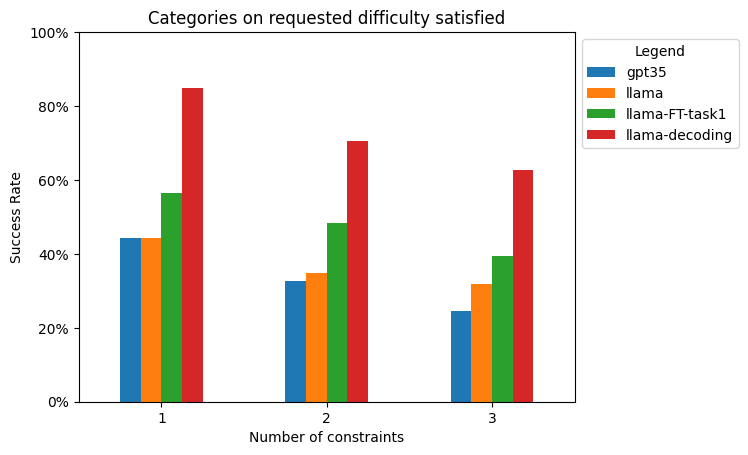

In [22]:
plot_sat(res, title="Categories on requested difficulty satisfied")

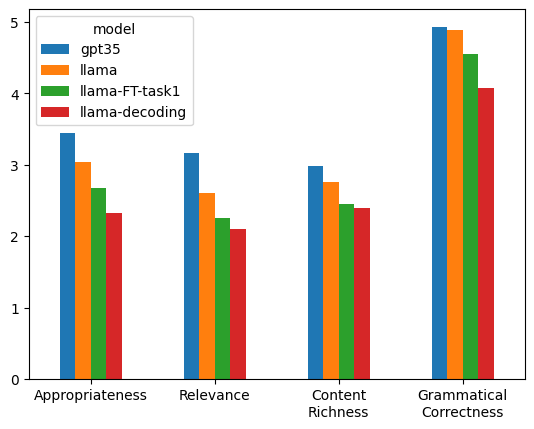

In [23]:
df =res.groupby(['model']).agg({**{col: 'mean' for col in ['Appropriateness', 'Relevance', 'Content Richness', 'Grammatical Correctness']}})
ax=df.transpose().plot(kind='bar', rot=0)
ax.set_xticklabels([l.get_text().replace(" ", "\n") for l in ax.get_xticklabels()])
plt.show()

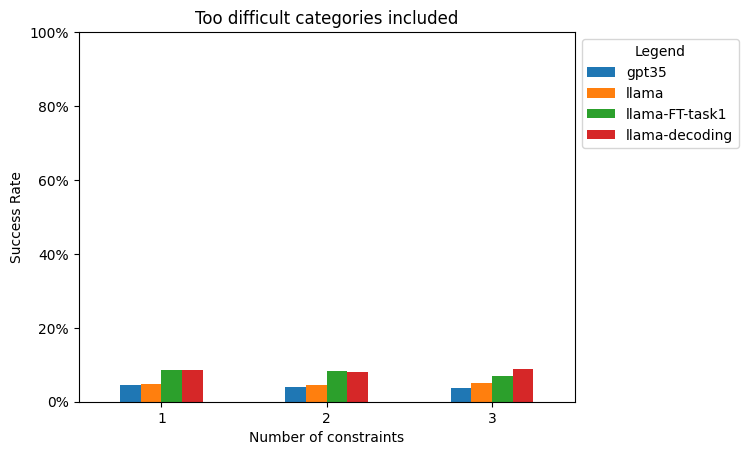

In [24]:
plot_sat(res, 'num_constraints_neg', title="Too difficult categories included")